## Importing packages and data

In [31]:
## Importing packages and data
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

import langchain  # Main LangChain import
from langchain_openai import ChatOpenAI  # To work with OpenAI
# from langchain_anthropic import ChatAnthropic # To work with Anthropic (optional)
# from langchain_google_genai import ChatGoogleGenerativeAI # To work with Gemini (optional)
from langchain_core.output_parsers import JsonOutputParser  # To help with structured output
from langchain_core.prompts import PromptTemplate  # To help create our prompt
from langchain_core.pydantic_v1 import BaseModel, Field  # To help with defining what output structure we want
from pydantic import BaseModel

from typing import List, Tuple

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage

import logging
import sys


In [32]:
# ==========================
# Configure Logging
# ==========================

# Create a logger
logger = logging.getLogger('ReWOO_LangGraph')
logger.setLevel(logging.DEBUG)

# Create handlers
c_handler = logging.StreamHandler(sys.stdout)
f_handler = logging.FileHandler('rewoolanggraph.log', mode='w')
c_handler.setLevel(logging.INFO)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add to handlers
c_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)


In [33]:
# ==========================
# Function to load JSON files
# ==========================

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [34]:
# ==========================
# Loading Files
# ==========================

base_path = 'arc-agi-genesis/data/challenges/'
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')

test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')

task_sets = {
    'training': {
        'challenges': training_challenges,
        'solutions': training_solutions,
    },
    'evaluation': {
        'challenges': evaluation_challenges,
        'solutions': evaluation_solutions,
    }
}

In [35]:
# ==========================
# Function to load tasks from a pre-loaded task set
# ==========================

def load_tasks_from_file(task_set):
    """
    Loads the tasks from the pre-loaded JSON data and returns the challenges and solutions tasks.
    """
    challenges = task_set['challenges']
    solutions = task_set['solutions']

    return challenges, solutions

In [36]:
# ==========================
# Print Dataset Information
# ==========================

print(f'Number of training challenges = {len(training_challenges)}')
print(f'Number of solutions of training challenges = {len(training_solutions)}')
# Loading tasks from the 'training' task set
challenges, solutions = load_tasks_from_file(task_set=task_sets['training'])
print(json.dumps(challenges['0520fde7'], indent=2))  # Accessing a specific challenge

Number of training challenges = 400
Number of solutions of training challenges = 400
{
  "test": [
    {
      "input": [
        [
          1,
          0,
          1,
          5,
          1,
          0,
          1
        ],
        [
          0,
          1,
          0,
          5,
          1,
          0,
          1
        ],
        [
          1,
          0,
          1,
          5,
          0,
          1,
          0
        ]
      ]
    }
  ],
  "train": [
    {
      "input": [
        [
          1,
          0,
          0,
          5,
          0,
          1,
          0
        ],
        [
          0,
          1,
          0,
          5,
          1,
          1,
          1
        ],
        [
          1,
          0,
          0,
          5,
          0,
          0,
          0
        ]
      ],
      "output": [
        [
          0,
          0,
          0
        ],
        [
          0,
          2,
          0
        ],
        [
    

#### initializing LLM client to use

In [37]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('api.env')

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')

# Initialize the ChatOpenAI model with the API key
llm = ChatOpenAI(model='gpt-4o-mini', openai_api_key=openai_api_key, max_tokens=3000)

## And incase you want to try Anthropic
# llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', api_key=UserSecretsClient().get_secret("ANTHROPIC_API_KEY"), max_tokens=3000)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"), max_tokens=3000)

## Trying to make MVP product which is just regular openai model trying to predict 

In [38]:
# converting train and test pairs to a string format ideal for LLMs
def json_task_to_string(challenge_tasks: dict, task_id: str, test_input_index: int) -> str:
    """
    challenge_tasks: dict a list of tasks
    task_id: str the id of the task we want to convert to a string
    
    Convert your json task into a string so you can pass it to your LLM.
    This is a crucial step where you can use your creativity to edit how tasks are represented.
    """
    json_task = challenge_tasks[task_id]

    final_output = ""

    train_tasks = json_task['train']
    test_task = json_task['test']

    final_output = "Training Examples\n"

    for i, task in enumerate(train_tasks):
        final_output += f"Example {i + 1}: Input\n["
        for row in task['input']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"
        final_output += f"Example {i + 1}: Output\n["

        for row in task['output']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"

    final_output += "Test\n["
    for row in test_task[test_input_index]['input']:
        final_output += f"\n{str(row)}"

    final_output += "]\n\nYour Response:"

    return final_output

In [39]:
# an example of how the function works
task_string = json_task_to_string(challenges, '0520fde7', 0)
print (task_string)

Training Examples
Example 1: Input
[
[1, 0, 0, 5, 0, 1, 0],
[0, 1, 0, 5, 1, 1, 1],
[1, 0, 0, 5, 0, 0, 0],]

Example 1: Output
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 2: Input
[
[1, 1, 0, 5, 0, 1, 0],
[0, 0, 1, 5, 1, 1, 1],
[1, 1, 0, 5, 0, 1, 0],]

Example 2: Output
[
[0, 2, 0],
[0, 0, 2],
[0, 2, 0],]

Example 3: Input
[
[0, 0, 1, 5, 0, 0, 0],
[1, 1, 0, 5, 1, 0, 1],
[0, 1, 1, 5, 1, 0, 1],]

Example 3: Output
[
[0, 0, 0],
[2, 0, 0],
[0, 0, 2],]

Test
[
[1, 0, 1, 5, 1, 0, 1]
[0, 1, 0, 5, 1, 0, 1]
[1, 0, 1, 5, 0, 1, 0]]

Your Response:


In [40]:
# Using a json output parser to parse the output, since LLMs aren't perfect at generating valid json
# Defining a prediction as a list of lists
class ARCPrediction(BaseModel):
    prediction: List[List] = Field(..., description="A prediction for a task")

## Setting up langgraph for mUlTiaGenTiC sYstEM

In [41]:
# Setting up the state for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    patterns: Annotated[list, add_messages]
    code: str
    prediction: List[List]
    task_string: str
    task_data: dict
    test_input_index: int




#### Generating nodes

In [42]:
# Building nodes for the graph
# first initialize the StateGraph
graph_builder = StateGraph(State)

def identify_logic(state: State):
    task_string = state['task_string']
    print(f"Identifying logic for task: {task_string}")
    prompt = PromptTemplate(
        template=(
            "You are an AI assistant specializing in puzzle solving.\n\n"
            "Given the following task, identify the logic or pattern present in the training examples.\n"
            "Provide a brief description of the logic in bullet points.\n\n"
            "Task:\n{task_string}\n\n"
            "Your response should be a brief description of the logic."
        ),
        input_variables=["task_string"]
    )

    chain = prompt | llm
    output = chain.invoke({"task_string": task_string}).content

    # Return as AIMessage object
    return {"messages": [AIMessage(content=output)]}

def recognize_patterns(state: State):
    messages = state['messages']
    previous_analysis = messages[-1].content  # Corrected access

    prompt = PromptTemplate(
        template=(
            "Based on the previous analysis, identify detailed patterns in the task.\n"
            "Focus on visual patterns, JSON structures, or any other relevant aspects.\n"
            "Provide the patterns as a list of concise statements.\n\n"
            "Previous analysis:\n{previous_analysis}\n\n"
            "Your response should be a list of patterns."
        ),
        input_variables=["previous_analysis"]
    )

    chain = prompt | llm
    output = chain.invoke({"previous_analysis": previous_analysis}).content

    return {"patterns": [output]}

def generate_code(state: State):
    patterns = state['patterns'][-1]  # Get the last patterns added

    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer.\n\n"
            "Given the following patterns, write Python code that solves the task according to these patterns.\n"
            "The code should define a function `solve_task(input_grid)` that returns the output grid.\n\n"
            "Patterns:\n{patterns}\n\n"
            "Your code:"
        ),
        input_variables=["patterns"]
    )

    chain = prompt | llm
    code = chain.invoke({"patterns": patterns}).content

    return {"code": code}

def revise_code(state: State):
    code = state['code']

    prompt = PromptTemplate(
        template=(
            "Review the following Python code and improve it if necessary.\n"
            "Ensure that it correctly implements the desired functionality and handles edge cases.\n\n"
            "Code:\n{code}\n\n"
            "Revised code:"
        ),
        input_variables=["code"]
    )

    chain = prompt | llm
    revised_code = chain.invoke({"code": code}).content

    return {"code": revised_code}

def execute_code(state: State):
    code = state['code']
    task_data = state['task_data']

    test_input_index = state['test_input_index']
    test_input = task_data['test'][test_input_index]['input']

    local_vars = {}
    global_vars = {}

    try:
        exec(code, global_vars, local_vars)
        if 'solve_task' in local_vars:
            solve_task = local_vars['solve_task']
        elif 'solve_task' in global_vars:
            solve_task = global_vars['solve_task']
        else:
            raise Exception("solve_task function not defined in code.")

        prediction = solve_task(test_input)
    except Exception as e:
        prediction = []
        print(f"Error executing code: {e}")

    return {"prediction": prediction}

#### Building the graph with eches

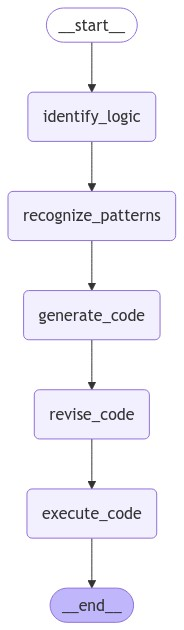

In [43]:
graph_builder.add_node("identify_logic", identify_logic)
graph_builder.add_node("recognize_patterns", recognize_patterns)
graph_builder.add_node("generate_code", generate_code)
graph_builder.add_node("revise_code", revise_code)
graph_builder.add_node("execute_code", execute_code)

graph_builder.add_edge(START, "identify_logic")
graph_builder.add_edge("identify_logic", "recognize_patterns")
graph_builder.add_edge("recognize_patterns", "generate_code")
graph_builder.add_edge("generate_code", "revise_code")
graph_builder.add_edge("revise_code", "execute_code")
graph_builder.add_edge("execute_code", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Creating function to get task prediction, make prompt, make API calls to model and parse output with retries

In [44]:
def get_task_prediction(challenge_tasks, task_id, test_input_index) -> List[List]:
    task_string = json_task_to_string(challenge_tasks, task_id, test_input_index)
    task_data = challenge_tasks[task_id]

    initial_state = {
        'task_string': task_string,
        'task_data': task_data,
        'test_input_index': test_input_index,
        'messages': [],
        'patterns': [],
        'code': '',
        'prediction': []
    }

    final_state = graph.invoke(initial_state)
    prediction = final_state['prediction']

    # Safety check
    if not all(isinstance(sublist, list) and all(isinstance(item, int) for item in sublist) for sublist in prediction):
        print("Warning: Output must be a list of lists of integers.")
        print(f"Errored Output: {prediction}")
        raise ValueError("Output must be a list of lists of integers.")

    num_rows = len(prediction)
    num_cols = len(prediction[0]) if num_rows > 0 else 0
    print(f"    Prediction Grid Size: {num_rows}x{num_cols}\n")

    return prediction


In [45]:
def run_model(challenges, NUM_ATTEMPTS=2, RETRY_ATTEMPTS=3, NUM_TASKS=None):
    """
    challenges: dict a list of challenges. This should come directly from your _challenges file
    NUM_ATTEMPTS: int the number of times to attempt a prediction. The official competition has 2 attempts.
    RETRY_ATTEMPTS: int the number of times to retry a prediction if it fails
    NUM_TASKS: int, If set, this represents the the number of tasks you'd like to test. If None then the all challeneges will be tested

    Loop through your challenges and produce a submission.json file you can submit for a score.
    """

    # A dict to hold your submissions that you'll return after all predictions are made
    submission = {}

    # Run through each task in your challenge set
    for i, task_id in enumerate(challenges):
        task_attempts = []  # List to store all attempts for the current task

        # Go through each test pair to get a prediction. 96% of challenges have 1 pair.
        for t, pair in enumerate(challenges[task_id]['test']):
            print(f"Starting task #{i + 1} ({task_id}), pair #{t+1}")

            # Dictionary to store attempts for the current test pair
            pair_attempts = {}  

            # Run through each prediction attempt
            for attempt in range(1, NUM_ATTEMPTS + 1):
                attempt_key = f"attempt_{attempt}"
                pair_attempts[attempt_key] = [] # Init your attempt

                # Try to get a prediction, with retries in case of failure
                for retry in range(RETRY_ATTEMPTS):
                    try:
                        print(f"    Predicting attempt #{attempt}, retry #{retry + 1}")
                        prediction = get_task_prediction(challenge_tasks=challenges,
                                                         task_id=task_id,
                                                         test_input_index=t)
                        
                        # If you get a valid prediction (list of lists of ints) with no error, then log the attempt
                        pair_attempts[attempt_key] = prediction
                        break  # Break the retry loop if prediction is successful
                    except Exception as e:
                        print(f"Retrying: {e}")
                        if retry == RETRY_ATTEMPTS - 1:
                            pair_attempts[attempt_key] = []  # Assign None if all retries fail

            # After you get your attempts, append them to the task attempts
            task_attempts.append(pair_attempts)

        # Append the task attempts to the submission with the task_id as the key
        submission[task_id] = task_attempts

        # If you want to stop after N tasks, uncomment the below
        if NUM_TASKS is not None and i + 1 == NUM_TASKS:
            break

    return submission

### Creating submission files and comparing it with solutions file

In [46]:
# create submission file
def create_submission_file(submission, file_name='submission.json'):
    """
    Save a submission file to the specified file name
    """
    with open(file_name, "w") as file:
        json.dump(submission, file)

    print (f"Submission saved to {file_name}")

In [47]:
# create function to compare submission with solutions
def score_submission(submission_file_name, solutions) -> Tuple[float, int]:
    """
    submission_file_name: str, the file name of your submission file
    solutions: dict, the ground truth solutions you'd like to test against
    
    Read a submission from file, score it, then return the score
    """
    print (f"Scoring {submission_file_name}\n")

    # Open your submission file
    with open(submission_file_name, "r") as file:
        submission = json.load(file)

    total_score = 0
    total_tasks = 0

    # Loop through each task in your submission to grade it
    for task_id, task_submission in submission.items():
        total_tasks += 1
        task_score = 0
        num_pairs = len(task_submission)

        # Go through each task. Most will only have 1
        for pair_index, pair_attempts in enumerate(task_submission):
            print(f"Scoring Task {task_id} pair #{pair_index+1}")
            pair_correct = False

            # Look at both of your attempts
            for attempt_key, attempt in pair_attempts.items():
                
                # check to see if one is correct
                if attempt == solutions[task_id][pair_index]:
                    print(f"Task Id {task_id} pair {pair_index+1} {attempt_key} matches solution")
                    pair_correct = True
                    break # If it is correct, log it and break the loop

            if pair_correct:
                task_score += 1

        task_score /= num_pairs
        total_score += task_score

    return {
        'total_score': total_score,
        'total_tasks_scored': total_tasks
    }

#### The main function to bring everything together

In [48]:
def main(task_set='training', NUM_TASKS=None, submission_file_name='submission.json'):
    # Load datasets
    challenges, solutions = load_tasks_from_file(task_set=task_sets[task_set])

    # # Run the model
    submission = run_model(challenges, NUM_TASKS=NUM_TASKS)

    # Create (and overwrite) a submission file
    create_submission_file(submission, file_name=submission_file_name)

    # Score the submission
    score_result = score_submission(solutions = solutions, submission_file_name=submission_file_name)

    print(f"Final score: {score_result['total_score']} of {score_result['total_tasks_scored']} ({round(score_result['total_score']/score_result['total_tasks_scored'] * 100, 2)}%)")

# RUNNING THE MODEL

In [49]:
main(task_set='evaluation', NUM_TASKS=2)

Starting task #1 (00576224), pair #1
    Predicting attempt #1, retry #1
Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response:


Error executing code: invalid decimal literal (<string>, line 1)
    Prediction Grid Size: 0x0

    Predicting attempt #2, retry #1
Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response:
Error executing code: invalid decimal literal (<string>, line 1)
    Prediction Grid Size: 0x0

Starting task #2 (009d5c81), pair #1
    Predicting attempt #1, retry #1
Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 8, 8, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 8, 